# Loading Packages

In [8]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import quandl

Populating the interactive namespace from numpy and matplotlib


# Mean Reversion

Augmented Dickey-Fuller (ADF) test: p-value = 0.89 accepts null hypothesis
It indicates no mean reversion exists in the time serie.

In [31]:
import statsmodels.tsa.stattools as ts
from datetime import datetime
amzn = quandl.get("WIKI/AMZN", start_date = "2005-01-01", end_date = "2015-1-1", api_key = "**").sort_index()
amzn.head()
ts.adfuller(amzn['Adj. Close'], 1)

(-0.502654064071864,
 0.8914975322764596,
 1,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 13867.020604373796)

# Stationary Time Series

## Hurst Exponent
#### H < 0.5 Mean Reversion
#### H = 0.5 Geometric Brownian Motion
#### H > 0.5 Trend
Amazon historical price is close to 0.5 GBM

In [36]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # return the Hurst Exponent from the polyfit output
    return poly[0]*2.0
# create a Geometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000)) + 1000)
mr = log(randn(100000) + 1000)
tr = log(cumsum(randn(100000) + 1) + 1000)
# output the Hurst Exponent for each of the above series
print("Hurst(GBM): %s" % hurst(gbm))
print("Hurst(MR): %s" % hurst(mr))
print("Hurst(TR): %s" % hurst(tr))
    
# The price of Amazon for the ADF test
print("Hurst(AMZN): %s" % hurst(amzn['Adj. Close']))  

Hurst(GBM): 0.49461749691169243
Hurst(MR): -0.00016085264741870278
Hurst(TR): 0.9582823828401705
Hurst(AMZN): 0.4467389791615432


# Cointegration

### 92% confidence that the residual is mean reverting

In [50]:
def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator() 
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim("2012-01-01", "2013-01-01")
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()
def plot_residuals(df):
    months = mdates.MonthLocator() # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim("2012-01-01", "2013-01-01")
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

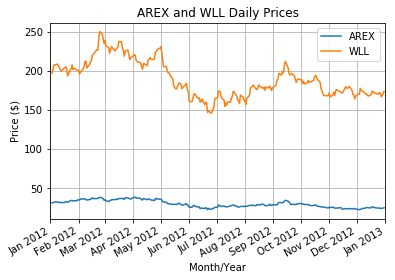

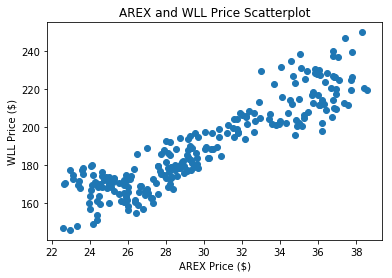

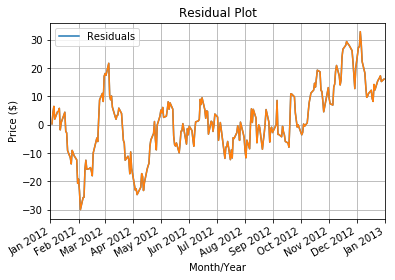

(-2.6399513265084398,
 0.08501801232987727,
 0,
 249,
 {'1%': -3.4568881317725864,
  '10%': -2.5729936189738876,
  '5%': -2.8732185133016057},
 1324.492947676295)


In [51]:
if __name__ == "__main__":
    start = "2012-01-01"
    end = "2013-01-01"
    arex = quandl.get("WIKI/AREX", start_date = start, end_date = end, api_key = "**").sort_index()
    wll = quandl.get("WIKI/WLL", start_date = start, end_date = end, api_key = "**").sort_index()
    df = pd.DataFrame(index=arex.index)
    df["AREX"] = arex["Adj. Close"]
    df["WLL"] = wll["Adj. Close"]
    plot_price_series(df, "AREX", "WLL")
    plot_scatter_series(df, "AREX", "WLL")
    y=df['WLL']
    x=df["AREX"]
    res = sm.OLS(y,x).fit()
    beta_hr = res.params.AREX
    df["res"] = df["WLL"] - beta_hr*df["AREX"]
    plot_residuals(df)
    cadf = ts.adfuller(df["res"])
    pprint.pprint(cadf)